# Starter Notebook - Spot The mask

This notebook is going to run through all the steps in creating a submission for this contest. If you want to skip the explanations, scroll down to the end for a minimal example submission from scratch.

# Setup

Before we can start modelling, we need to get the data somehow. Since this example is running in Colab, you have several options:
- Upload everything through the 'Files' tab on the left
- Upload the files to your Google Drive and then use the 'Mount Drive' option to oad your drive like and external hard drive.
- Download the files directly from Zindi

I've uploaded the two CSV files manually, since they're small. The images are only ~200MB zipped, but why wste your home internet? Here's a tip for getting the files straight to Colab: start a download, cancel it and then copy the link. You can then use the line of code below to download the file:

In [1]:
# Start a download, cancel and copy the link here to pull the data straight to Colab:
!curl "https://zindpublic.blob.core.windows.net/private/uploads/competition_datafile/file/404/images.zip?.....YOUR_DOWNLOAD_LINK" > images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   223  100   223    0     0    340      0 --:--:-- --:--:-- --:--:--   340


The data comes in a zip file. This command extracts it into the 'images' folder. The '-q' option stops it listing all the files and keeps our notebook looking tidy.

In [ ]:
# Extracting the files
!unzip -q images.zip

Normally, Colab is great in that everything you need to get started is present. However, just before we launched this, some library got updated and was causing issues with the data augmentations. A quick search for the error led me to this fix:

In [ ]:
# Right now there's an issue with library versions on Colab that doesn't play nicely with this example. The fix:
# Force things to known-good versions for now and hope it gets fixed in the future.
!pip install "torch==1.4" "torchvision==0.5.0" # Only need to run this once

With that out the way, we can load in some libraries. It's good practice to keep all your imports right at the top. THe most important ones here are pandas (for making it easy to work with tabular data) and fastai (for the actual deep learning).

In [ ]:
# Importing the libraries we'll be using
from fastai.vision import *
import pandas as pd
import PIL
from IPython.display import Image as ShowImage
from matplotlib import pyplot as plt

# Taking a look at the data

The labels come as a CSV file. For convenience and to check out the data, we can load it into a dataframe using pandas.

In [ ]:
# We read the labels into a csv file using the pandas library:
train_labels = pd.read_csv('train_labels.csv')
train_labels.head() # .head() shows the first few rows

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


We have the image name, and a correspinding 'target'. This is the label for that image. 1 means mask, 0 means no mask. We want to build a model that can generate this label.

You can view an image in many ways. In the imports section above, I imported the Image option from IPython.display as 'ShowImage' - this makes it easy to get images right in the notebook without any fuss. Here, we look at the first image:

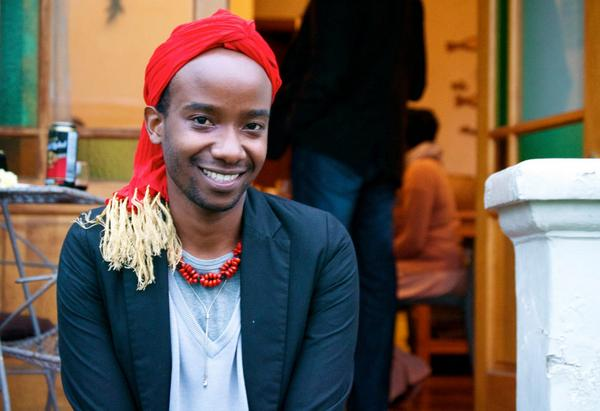

In [ ]:
# We can view an image with:
ShowImage('images/tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg')

In [ ]:
# Exercise: Check a few images, and see if the labels are correct
# Bonus: Don't copy in the image names manually - instead, read them from the train_lables dataframe

# Getting the data ready for the model

We need to package the data in a way that can be fed into our model for training. In fastai, this involves something called a 'DataBunch'. This contains the images and labels, and keeps track of and processing done to the images(like resizing or cropping) as well as sorting them into batches, keeping some for validation (scoring the model) etc.

There are lots of ways to build a databunch - here are three examples. If your data comes in a different format, chances are there are examples on the web showing how to deal with that. For more info, check out the docs at https://docs.fast.ai

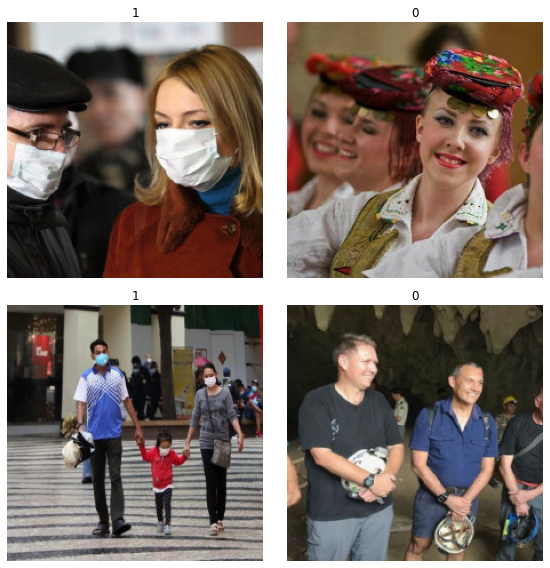

In [ ]:
# Option 1: Imagelist from file -> databunch
path = Path('')
src = ImageList.from_csv(path, 'train_labels.csv', folder='images')\
                        .split_by_rand_pct(0.15)\
                        .label_from_df()\
                        .transform(get_transforms(), size=224)
data = src.databunch(bs=32)
data.show_batch(rows=2)

You can see the labels above the images.

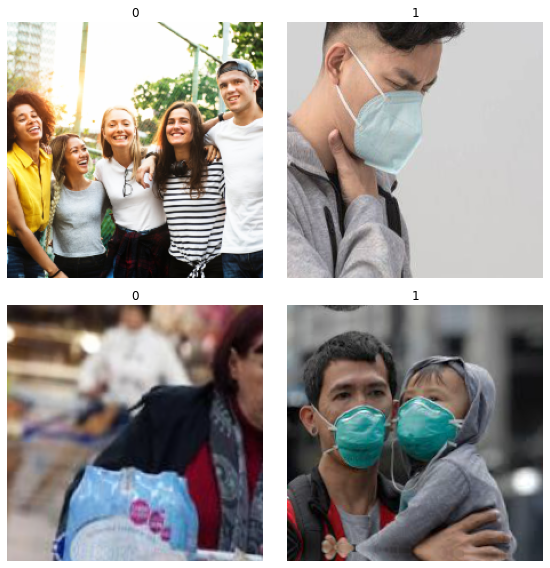

In [ ]:
# Option 2: straight to databunch
data = ImageDataBunch.from_csv(path='', csv_labels='train_labels.csv', folder='images',
                               valid_pct=0.15, # < could leave at default 0.2
                               fn_col='image', # < don't have to specify since fastai assumes the first column, but just in case:
                               label_col='target', # < again, we could leave this out
                               ds_tfms = get_transforms(), # <Data augmentation: see next section
                               size=224, bs=32) # Image size and batch size. Reduce batch size if you're running out of memory
data.show_batch(rows=2)

This one does the same thing, but the syntax is slightly different. Which do you prefer?

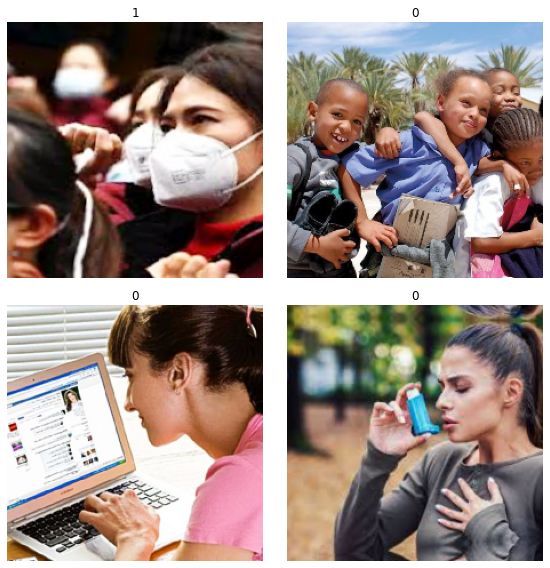

In [ ]:
# Option 3: Go from the dataframe
data = ImageDataBunch.from_df(path='images', df=train_labels,ds_tfms = get_transforms(),size=224, bs=32)
data.show_batch(rows=2)

All three of these examples do essentially the same thing (although option 3 leaves a few parameters at their defaults). You can see that there isn't one correct answer. Look around for examples similar to the problem you're trying to solve, and see how others have done it.

With the hard bit now done, it's time to train a model!

# Time for training!

Now it's time to train a model. We're going to take advantage of transfer learning, and start with a nice pretrained model. There are many to choose from (https://docs.fast.ai/vision.models.html). Here, we'll use a ResNet50. There are fancier models that might take longer to train but can give better accuracy - check out the minimal example at the end of this notebook to see a densenet in action.

Creating a 'learner' with our chosen model architecture is as simple as:

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

We've passsed in accuracy as a metric, out of interest. The 'valid_loss' displayed during training is the log loss, and should closely match your score on Zindi.

We could start training, but first let's use a cool trick to pick our learning rate:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


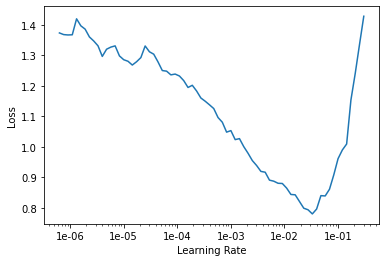

In [ ]:
learn.lr_find()
learn.recorder.plot()

This graph tells us at what point a higher learning rate stops leading to an improvement. We want to pick one in the part of the graph trending sharply downwards - in this case I choose 1e-3, but you could go slightly higher and still be fine.

With our learning rate chosen, it's time to train. With a pre-trained model, the default is to only train the 'head' of the model - the end bit that makes the final predictions. We'll do this first, but then unfreeze the model and train some more to get better performance.

In [ ]:
# Train the head
learn.fit_one_cycle(3, 1e-3) # Number of epochs to train, and the learning rate we chose

epoch,train_loss,valid_loss,accuracy,time
0,0.420961,0.214553,0.931035,00:45
1,0.263991,0.105287,0.969349,00:44
2,0.162986,0.109477,0.969349,00:44


We're already at 97% accuracy! Amazing. Now to fine-tune, we will unfreeze the network and train some more, using a lower learning rate. In this case we pass slice(1e-6, 1e-4) to tell the network to train different layers at different learning rates. How do we get these values? Copy the fastai examples, or use lr_find and plot again and pick a range that falls well before the sharp rise in loss. In general, picking something 10x smaller than your first learning rate will be an adequate strategy.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.119443,0.109415,0.973180,00:45
1,0.106385,0.096391,0.973180,00:45
2,0.093349,0.096582,0.969349,00:45


That valid_loss figure of ~0.1 is pretty good. We should get about the same on Zindi, but how do we make submissions?

# Making Predictions

The sample submission file lists the test images, and shows a target column of all 0s. We want to replace those 0s with our predicted targets - close to 1 for mask, close to 0 for no mask. We'll be scored on how close we are to the true values, but if we simply put 1s and 0s then any mistakes will result in a bad score. Instead, we'll use the model's raw outputs instead. That way, whhen the model is confident, we predict close to 1. But when it's unsure, we predict something lower (say 0.8, or 0.2 if it's probably no mask) and if it's wrong we won't get such a large penalty.

In [ ]:
# Read in the sample submission file
ss = pd.read_csv('sample_sub_v2.csv')
ss.head()

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0


To make predictions, we add a test set to the model's databunch, like so:

In [ ]:
# Create a test set to pass to our learner
test = (ImageList.from_df(path='', df=ss, folder='images'))
learn.data.add_test(test)

Now we can get predictions:

In [ ]:
# Get predictions
preds, labels = learn.get_preds(DatasetType.Test)

In [ ]:
# What do these look like?
preds[0] # The first prediction

tensor([0.8198, 0.1802])

The predictions take the firm [P(no_mask), P(mask)]. We want the second one, and we can add it to our target column like so:

In [ ]:
# we want p(Mask) for our submission, so we'll look at the second number in each prediction with p[1]
ss['target'] = [float(p[1]) for p in preds]
ss.head()

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0.180151
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0.000009
2,aclkjfvackiieiznzfcwienplielrj.jpg,1.000000
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0.999897
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0.000040


In [ ]:
# Save the file
ss.to_csv('starter_nb_baseline.csv', index=False)

You can submit to Zindi to see how well this does!

# Making it better

There are some easy ways to boost your score.
- Use test time augmentation (tta)
- Try a fancier model
- Train more (not always better, but training for a few more epochs will probably help)
- Combine predictions from several models.

Let's try a few of these

In [ ]:
# TTA is easy - use .TTA() in place of .get_preds()
preds_tta, labels_tta = learn.TTA(ds_type=DatasetType.Test)
ss['target'] = [float(p[1]) for p in preds_tta]
ss.to_csv('starter_nb_tta.csv', index=False)

It takes longer, since it's making predictions on 8 variations of each test image. But TTA usually gives a better score. Did it work for you?

Now for combining predictions. There are many ways of doing this, but let's take the easy route and assume you've got several CSV files with previous submissions. Here, we load some in and take the average. Of course, we should really combine predictions from DIFFERENT models, but this is just for illustration. It's up to you to train a few more models and combine :)

In [ ]:
# Average of two sets of predictions
preds1 = pd.read_csv('starter_nb_baseline.csv')
preds2 = pd.read_csv('starter_nb_tta.csv')
av_preds = pd.DataFrame({
    'image':preds1['image'],
    'target': 0.5*preds1['target'] + 0.5*preds2['target']
})
av_preds.to_csv('ensemble1.csv', index=False)

# Exercise: Run the minimal example below and combine those predictions with the tta submission from above

# Exercise: If one model is substantailly better, we may want it's predictins to count more towards the final prodiction.
#          Try to use 0.8*good_predictions + 0.2*other_predictions to skey your ensemble predicitons towards the better model's outputs.

# Minimal Example

We've got a lot of explanation in here, but here is a minimal submission from scratch. You'll notice we're using a fancier model. Is it better? You'll have to test and find out. We're also just using the same learning rates from the earlier examples - not ideal, so see if you can improve.

We're also adding .mixup() since that sounds fancy, and training for longer than the example. Feel free to play with this, and see how good you can get it!

Good luck :)


In [ ]:
from fastai.vision import *

# Setup and training
data = ImageDataBunch.from_csv(path='', csv_labels='train_labels.csv', folder='images', ds_tfms = get_transforms(), size=330, bs=16)
learn = cnn_learner(data, models.densenet201, metrics=accuracy).mixup()
learn.fit_one_cycle(3, 1e-3)
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

# Predictions
ss = pd.read_csv('sample_sub_v2.csv')
learn.data.add_test((ImageList.from_df(path='', df=ss, folder='images')))
preds, labels = learn.get_preds(DatasetType.Test)
ss['target'] = [float(p[1]) for p in preds]
ss.to_csv('starter_nb_baseline2.csv', index=False)

epoch,train_loss,valid_loss,accuracy,time
0,0.752703,0.244748,0.892720,01:02
1,0.667191,0.131598,0.957854,00:51
2,0.546684,0.074023,0.977012,00:52


epoch,train_loss,valid_loss,accuracy,time
0,0.517617,0.072357,0.969349,00:58
1,0.491976,0.089628,0.965517,00:56
2,0.469409,0.075067,0.969349,00:56
3,0.454277,0.073448,0.965517,00:56
4,0.431286,0.078341,0.969349,00:56
